In [66]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import h5py as h5py
from time import time
import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

In [2]:
data = np.load("processed_data.npz")

In [3]:
data.files

['x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test']

In [4]:
data['x_train'].shape

(153582, 47)

In [5]:
max_episode = 10

def get_padded_matrix(x_, y_):
    episode_matrix = np.zeros(shape=[x_.shape[0], max_episode, x_.shape[1]])
    episode = []
    for idx in range(len(x_)):
        # within on episode
        episode.append(x_[idx])
        for event_idx in range(min(len(episode), max_episode)):
            episode_matrix[idx][-(event_idx%max_episode)-1] = episode[-event_idx - 1]
        if np.equal(x_[idx][:-1],y_[idx]).all():
            # episode changed
            episode = []
    return episode_matrix

In [6]:
train_matrix = get_padded_matrix( data['x_train'],  data['y_train'])

In [7]:
valid_matrix = get_padded_matrix( data['x_valid'],  data['y_valid'])

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_matrix.shape[2]-1)
])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                19600     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                5934      
Total params: 32,062
Trainable params: 32,062
Non-trainable params: 0
_________________________________________________________________


In [10]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
try:
    model.load_weights("model_noembed_weights.h5py")
    print("Loaded saved model :)")
except OSError:
    print("No saved model. Training from scratch.")
    tensorboard = keras.callbacks.TensorBoard(log_dir="logs/lstm_no_embed{}".format(time()))
    model.fit(train_matrix, data['y_train'], validation_data=(valid_matrix, data['y_valid']), epochs=0, callbacks=[tensorboard])
    model.save_weights("model_noembed_weights.h5py")

Loaded saved model :)


Train on 153582 samples, validate on 19527 samples
Epoch 1/5
153582/153582 [==============================] - 65s 424us/step - loss: 0.1745 - val_loss: 0.1185
Epoch 2/5
153582/153582 [==============================] - 68s 441us/step - loss: 0.1390 - val_loss: 0.1156
Epoch 3/5
153582/153582 [==============================] - 66s 427us/step - loss: 0.1369 - val_loss: 0.1170
Epoch 4/5
153582/153582 [==============================] - 66s 432us/step - loss: 0.1360 - val_loss: 0.1132
Epoch 5/5
153582/153582 [==============================] - 73s 475us/step - loss: 0.1354 - val_loss: 0.1149


In [19]:
valid_predicted = model.predict(valid_matrix)

In [110]:
train_predicted = model.predict(train_matrix)

In [18]:
columns = ['ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive']

In [24]:
valid_predicted[0:11,columns.index('HeartRate')]

array([-0.77627414, -0.57108986, -0.49307466, -0.47101998, -0.45567146,
       -0.4930166 , -0.14175913, -0.10361874, -0.09939028, -0.2909848 ,
       -0.8148831 ], dtype=float32)

In [113]:
sns.set(style="white")

def plot(column, mode, prediction):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(data['y_'+mode][0:200,columns.index(column)], label="truth")
    plt.plot(prediction[0:200,columns.index(column)], label="predicted")
    plt.legend(["truth", "predicted"])
    plt.title(column + " " + mode)
    plt.show()

In [104]:
valid_matrix[1]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.     

In [105]:
data['y_valid'][1]

array([-0.05892545, -0.22482989, -0.39348202,  0.2548058 , -0.29395205,
       -0.00399861, -0.21842662, -0.06035766, -1.1738481 , -0.03417624,
       -0.5268577 , -0.4191935 ,  0.77405447,  0.8243672 , -0.18490073,
       -0.25273826, -0.99517434, -0.07411374, -0.41727737, -0.21020553,
       -0.28222038, -0.59324696, -0.62861989, -0.13372822,  0.4491106 ,
       -0.85909463,  0.43935512, -0.52623509,  0.36262002,  0.85519488,
       -1.64672869, -0.28302509, -0.17665989,  2.24966532,  0.03377865,
       -0.11904791, -1.17080641, -1.11069097,  0.03406687, -2.09460004,
        0.16935475,  0.54002171, -0.57893045,  0.3906546 , -0.51694303,
       -0.68418577])

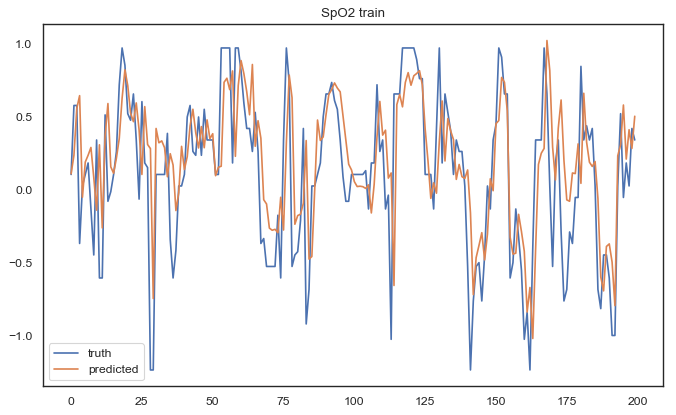

In [114]:
plot("SpO2", "train", train_predicted)

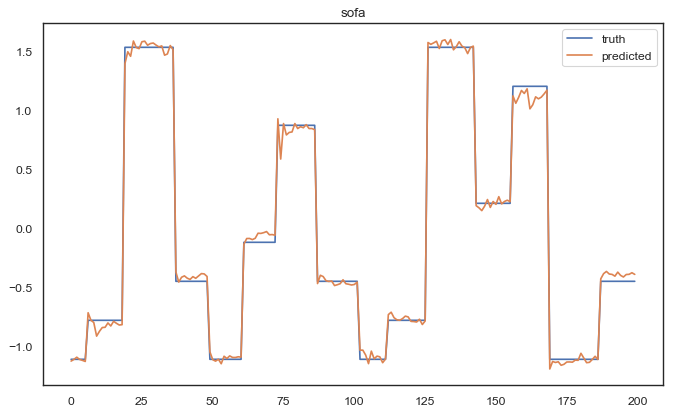

In [85]:
plot("sofa")

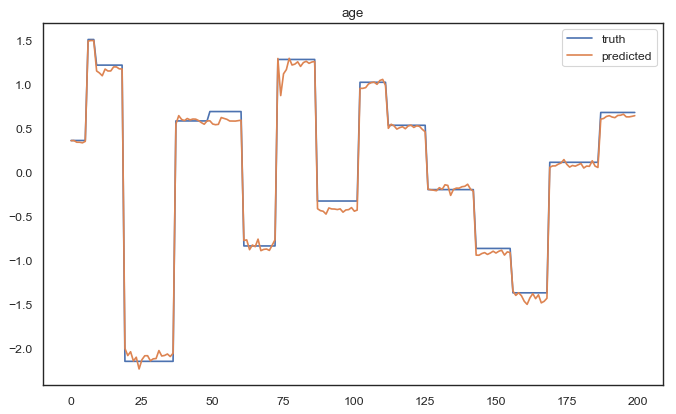

In [86]:
plot("age")

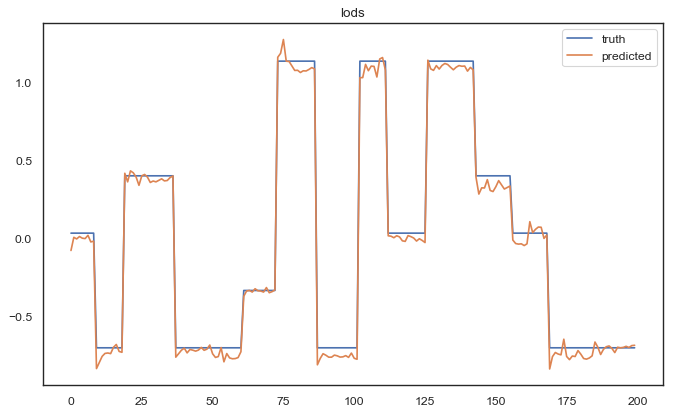

In [87]:
plot("lods")

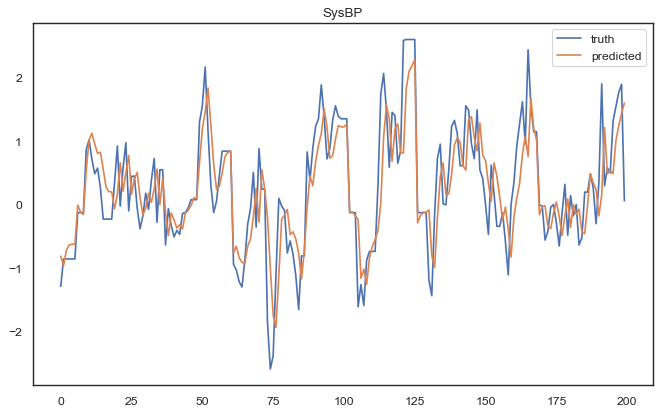

In [88]:
plot("SysBP")

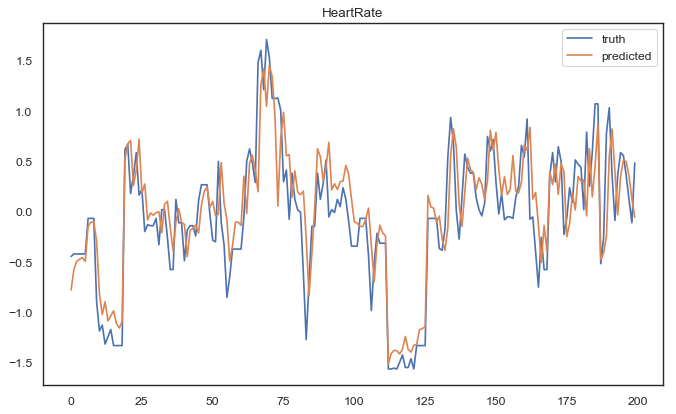

In [106]:
plot("HeartRate")

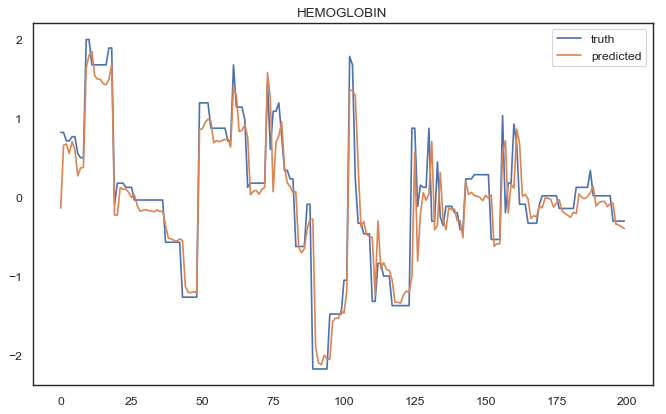

In [108]:
plot("HEMOGLOBIN")

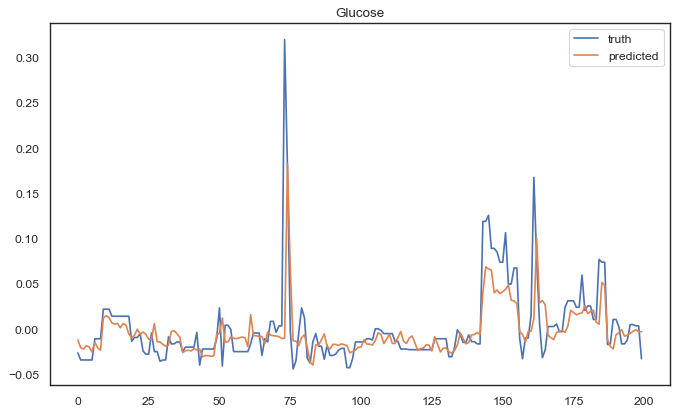

In [109]:
plot("Glucose")